<a href="https://colab.research.google.com/github/skaty5678/basics_of_GANs/blob/main/GANs_fashion_mnist_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies and data

In [54]:
#pip install required dependencies
#!pip install tensorflow matplotlib tensorflow-datasets ipywidgets 

In [55]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [56]:
#Use the tensorflow datasets api to bring in the data source 
ds = tfds.load('fashion_mnist',split = 'train')

In [57]:
ds.as_numpy_iterator().next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

# Visualize Data and buid Dataset

In [58]:
#do some data transformation
import numpy as np

In [59]:
#setup connection aka iterator
data_iterator = ds.as_numpy_iterator()

In [ ]:
data_iterator.next()

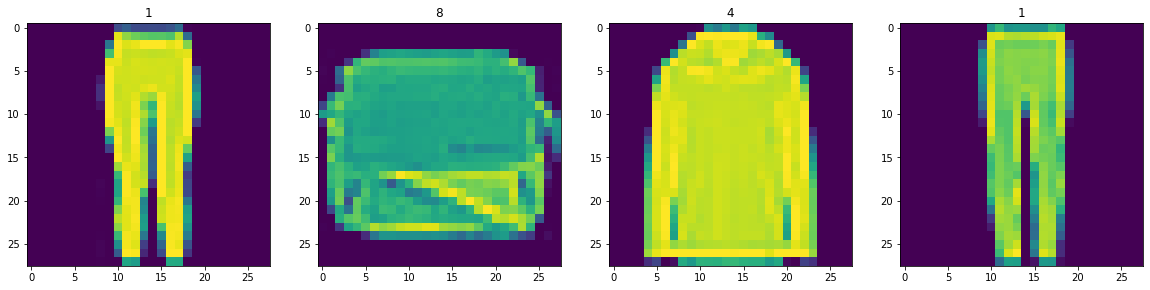

In [61]:
#subplot formatting
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
#loop 4 times and get images
for idx in range(4):
  sample = data_iterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [62]:
#scale and return image only
def scale_image(data):
  image = data['image']
  return image /255

In [63]:
#reload the dataset
ds = tfds.load('fashion_mnist',split='train')
#running the dataset through the scale image preprocessing
ds = ds.map(scale_image)
#cache the dataset for that batch
ds = ds.cache()
#shuffle it
ds = ds.shuffle(60000)
#batch into 128 images per sample
ds = ds.batch(128)
#reduce the likelihood of bottleneck
ds = ds.prefetch(64)

In [64]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# Build the neural network

## import modelling components

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, UpSampling2D, Dropout

## Build the generator

In [66]:
def build_generator():
  model = Sequential()

  #takes in random values and reshapes it to 7,7,128
  #beginnings of a generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  #conv layer to get to one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))


  return model

In [67]:
test_model = build_generator()

In [68]:
test_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [69]:
generator = build_generator()

In [80]:
img = generator.predict(np.random.randn(4,128,1))


In [81]:
img.shape

(4, 28, 28, 1)

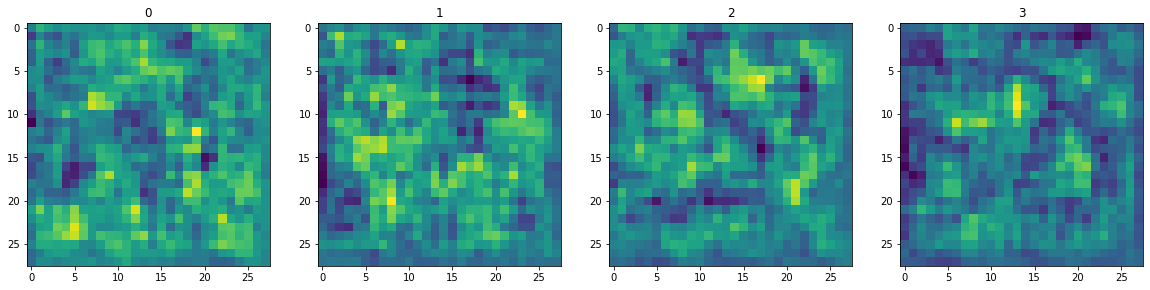

In [70]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

## build discriminator

In [71]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 


In [72]:
discriminator = build_discriminator()

In [73]:
discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 128)      

In [82]:
img = img[0]


In [84]:
img.shape


(28, 28, 1)

In [85]:
discriminator.predict(np.expand_dims(img,0))


array([[0.48434335]], dtype=float32)

# Construct training loop

## setup loss and optimizers

In [86]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

## Build subclass model

In [87]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [88]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [ ]:
class gan_fashion(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    #pass through args and kwargs to base class
    super().__init__(*args,**kwargs)

    #create attributes for generator and discriminator
    self.generator = generator
    self.discriminator = discriminator

    


  def compile(self,g_opt,d_opt,g_loss,d_loss,*args,**kwargs):
    #compile with base class
    super().__init__(*args,**kwargs)

    #create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss




  def train_step(self,batch):
    #get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128,128,1)),training = False)

    #train the discriminator
    with tf.GradientTape() as d_tape:

      #pass the real and fake images
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([real_images,fake_images],axis=0)


      #create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)
      #add some noise to the outputs
      #calculate loss
      # apply backpropagation -nn learn





    pass
